In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

complaints_df = pd.read_csv('../data/complaints.csv', delimiter=',')
complaints_df = complaints_df[['Consumer complaint narrative','Company','Company response to consumer']].copy()
complaints_df.columns = ['Narrative','Company', 'Response'] 
complaints_df.head()

,Narrative,Company,Response
0,I have complained many times that the credit r...,Experian Information Solutions Inc.,Closed with explanation
1,please review the current fraud account and al...,"Ideal Collection Services, Inc.",Closed with explanation
2,Called multiple times over the years for a deb...,"ONEMAIN FINANCIAL HOLDINGS, LLC.",Closed with explanation
3,I sent in a letter to the company to have them...,"Diversified Consultants, Inc.",Closed with explanation
4,On XX/XX/19 I applied for a Debt Relief Produc...,"ClearOne Advantage, LLC",Closed with explanation


Complaints worden gefilterd: enkel de 10 grootste bedrijven blijven over. Dit maakt het makkelijker om het aantal klachten per bedrijf te plotten, samen met de categorie van antwoord naar de klant toe.

In [89]:
counts = complaints_df.groupby('Company').count().reset_index()
biggest_companies = counts.sort_values(by='Response', ascending=False).head(10)['Company'].to_list()
print(biggest_companies)
complaints_filtered = complaints_df[complaints_df['Company'].isin(biggest_companies)]
response_counts = pd.DataFrame({'Count': complaints_filtered.groupby(['Company', 'Response']).size()})
response_counts.head(10)

['EQUIFAX, INC.', 'Experian Information Solutions Inc.', 'TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'WELLS FARGO & COMPANY', 'CITIBANK, N.A.', 'BANK OF AMERICA, NATIONAL ASSOCIATION', 'JPMORGAN CHASE & CO.', 'Navient Solutions, LLC.', 'CAPITAL ONE FINANCIAL CORPORATION', 'SYNCHRONY FINANCIAL']


Count
Company                               Response                              
BANK OF AMERICA, NATIONAL ASSOCIATION Closed                              98
                                      Closed with explanation          10579
                                      Closed with monetary relief       3639
                                      Closed with non-monetary relief   1392
                                      In progress                          1
CAPITAL ONE FINANCIAL CORPORATION     Closed                              10
                                      Closed with explanation          10548
                                      Closed with monetary relief       1187
                                      Closed with non-monetary relief   1311
CITIBANK, N.A.                        Closed                              13

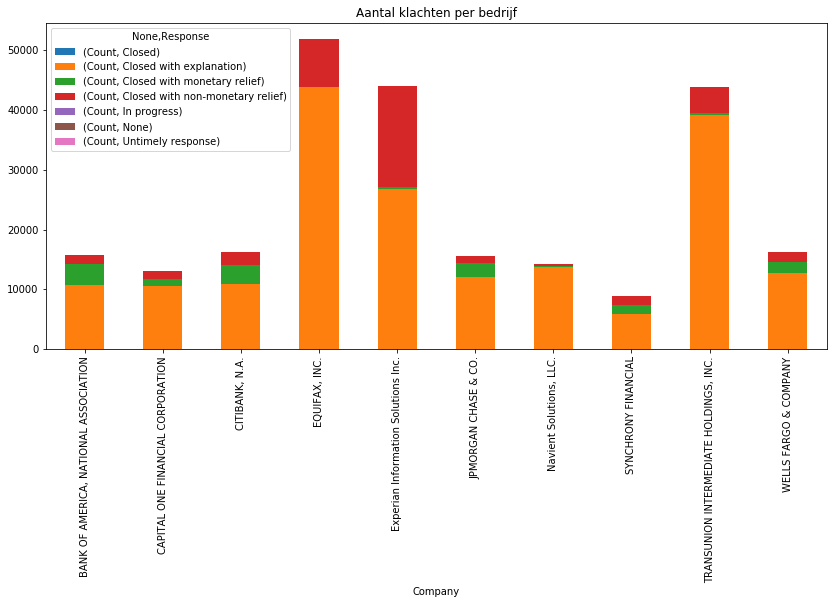

In [99]:
response_counts.unstack().plot(kind='bar', figsize=(14,6), stacked=True, title="Aantal klachten per bedrijf")